# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

Group member:
Dejie Li , Xingshen Chen

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [15]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np
import math

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# data cleaning
import missingno as msno

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


In [16]:
# helper function
def classification_model_fit(model, X_test, y_test, model_name="Model"):
    """
    Evaluate the performance of a binary classification model and plot the confusion matrix.
    
    Parameters:
    model      : Trained sklearn classification model (e.g., LogisticRegression)
    X_test     : Feature matrix of the test set
    y_test     : True labels of the test set
    model_name : Optional name to display in plot titles
    """

    # Get predicted class labels
    y_pred = model.predict(X_test)
    
    # Get predicted probabilities (used for ROC AUC)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Print metrics
    print(f" Evaluation Metrics ({model_name})")
    print("-" * 30)
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print(f"ROC AUC Score  : {auc:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    labels = ['Prepaid (0)', 'Default (1)']

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14)
    plt.show()

    # Optionally return the results as a dictionary
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        "confusion_matrix": cm
    }


# Introduction


### 1.1 Research Background and Significance
Credit default risk assessment is a crucial task in the credit industry. An effective default prediction model can help financial institutions identify high-risk borrowers, reduce losses from non-performing loans, and enhance the fairness and accuracy of credit decision-making. With the growing availability of data, machine learning-based risk modeling has become increasingly popular. This project aims to develop an interpretable classification model to predict loan defaults and identify key factors contributing to the likelihood of default, thereby supporting data-driven decisions in credit risk management.

### 1.2 Data Source
The dataset used in this study comes from the Freddie Mac Single-Family Loan-Level Dataset. We use a simplified version focusing on the years 2017 to 2020. It includes detailed loan-level information such as borrower credit scores, loan terms, property characteristics, geographic location, loan-to-value ratios, and repayment statuses. The target variable, loan_status, contains three possible values: default, prepaid, and active. Special codes such as 999 and 9 are used to indicate missing values in some features, and we apply data cleaning and imputation strategies during preprocessing to handle them appropriately.

### 1.3 Research Objective
The primary goal of this project is to build a classification model that accurately predicts the probability of loan default. We first extract all loans labeled as either default or prepaid and split them into training and test sets for model development and evaluation. Once validated, the trained model is then applied to the remaining active loans to predict potential defaults. Additionally, we aim to identify and interpret the most important predictors of loan default to support more informed credit risk assessments and policy design.

### 1.4 Methodology
We applied multiple classification algorithms including Logistic Regression, Lasso, Random Forest, and XGBoost to predict loan default. To address the severe class imbalance, we experimented with resampling techniques such as SMOTE and Random Undersampling. After evaluating model performance across precision, recall, accuracy, and AUC, we selected the Random Forest with undersampling as our final model. Preprocessing steps such as imputation and one-hot encoding were applied to ensure model compatibility and interpretability.

### 1.5 Conclusion
Our final model effectively identifies potential defaults with strong recall performance and reasonable interpretability. By analyzing feature importance from the Random Forest model, we identified key risk indicators such as low FICO scores and high loan amounts. While the model performs well, its limitation lies in the absence of a formal cost function to quantify the impact of different types of errors. Future work could focus on incorporating economic cost estimations to better guide decision-making.

# Exploratory Data Analysis and Feature Engineering


## 2.1 Dataset Feature Desctiptions
The dataset used in this project originates from a mortgage loan performance dataset released by Fannie Mae, a government-sponsored enterprise in the United States. It includes detailed information about mortgage loans issued over multiple years, covering borrower characteristics, loan terms, property features, and loan performance outcomes such as whether the loan was prepaid or defaulted.



In [17]:
# We load the data below
d = pd.read_csv("freddiemac.csv")
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,NaN,NaN,9,NaN,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
4,790,201703,N,204702,41620.0,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active


We have the following numerical features in our data:

- **fico**: Credit score of the borrower at origination.  
- **dt_first_pi**: First payment date (YYYYMM).  
- **dt_matr**: Scheduled loan maturity date.  
- **mi_pct**: Mortgage insurance percentage.  
- **cltv**: Combined loan-to-value ratio.  
- **dti**: Debt-to-income ratio.  
- **orig_upb**: Original unpaid principal balance.  
- **ltv**: Loan-to-value ratio at origination.  
- **int_rt**: Interest rate of the loan.  
- **orig_loan_term**: Original term length of the loan (in months).  

We have the following categorical features in our data

- **flag_fthb**: First-time homebuyer indicator.  
- **occpy_sts**: Occupancy status of the property.  
- **channel**: Loan origination channel.  
- **st**: State where the property is located.  
- **prop_type**: Property type.  
- **loan_purpose**: Purpose of the loan.  
- **seller_name**: Seller of the loan.  
- **servicer_name**: Entity servicing the loan.  
- **flag_sc**: Super conforming loan indicator.  
- **program_ind**: Loan program indicator.  
- **rr_ind**: Re-performing refinance indicator.  
- **cd_msa**: Metro area indicator.  
- **cnt_borr**: Number of borrowers.  
- **property_val**: Property valuation method.  
- **mi_cancel_ind**: Mortgage insurance cancellation status.  
- **cnt_units**: Number of housing units.

- We excluded non-feature columns such as **ID** and **loan_status**, as they are either identifiers or already used to define the target variable.
- We dropped the columns **ppnt_pnlty**, **prod_type**, and **io_ind** because each of them contains only a single unique value across all loans, providing no variance or predictive power for modeling.
- The **zipcode** column was also discarded. Although it could represent geographic information, we already included the state abbreviation (**st**) as a regional indicator. Using **zipcode** as a numeric variable is not meaningful, and treating it as a categorical variable would introduce too many levels, which is inappropriate for most machine learning models.

## 2.2 Test-Training Spilt
To ensure a fair evaluation and prevent data leakage, we first split the dataset into training and testing subsets before performing any data preprocessing or exploratory analysis. In this case, we retained only the loans with status 'default' and 'prepaid', and then constructed a binary target variable where 1 indicates default and 0 indicates prepaid.

We used an 80/20 train-test split with stratification on the target variable to preserve the proportion of default cases in both sets. The stratified split is particularly important due to the imbalanced nature of the dataset. This early split ensures that the test set remains completely unseen throughout the entire feature engineering and model training process, avoiding any leakage of information that could lead to over-optimistic model performance.

By working only with the training set during preprocessing and EDA, we maintain a clean pipeline that mirrors real-world deployment scenarios and results in more trustworthy evaluation metrics.

In [18]:
# classify categorical and numerical varaiables
categorical_columns = [
    'flag_fthb', 'occpy_sts', 'channel', 'st',
    'prop_type', 'loan_purpose', 'seller_name',
    'servicer_name', 'flag_sc', 'program_ind', 'rr_ind',
    'cd_msa', 'cnt_borr', 
    'property_val', 'mi_cancel_ind','cnt_units'
]

numerical_columns = [
    'fico', 'dt_first_pi', 'dt_matr',  'mi_pct',
     'cltv', 'dti', 'orig_upb', 'ltv',
    'int_rt', 'orig_loan_term'
]

feature_columns = categorical_columns + numerical_columns

data_labeled = d[d['loan_status'].isin(['default', 'prepaid'])]

data_labeled['target'] = (data_labeled['loan_status'] == 'default').astype(int)

X = data_labeled[feature_columns]
y = data_labeled["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

eda_data = X_train.copy()
eda_data['loan_status'] = y_train

## 2.3 Handing Missing Data

In this dataset, missing values are not consistently represented as standard `NaN`, but are instead encoded using placeholder values such as `9`, `99`, `999`, or `9999`, depending on the column. 

To facilitate consistent missing value handling in the preprocessing stage, we first created a mapping (`missing_value_map`) that specifies which placeholder values correspond to missing data for each relevant column. 

We then applied this mapping across the dataset to replace all these special codes with proper `NaN` values using the `.replace()` function. This ensures that later stages of analysis and imputation can recognize and treat these entries as standard missing data.

In [19]:
# define missing value map
missing_value_map = {
    'fico': [9999],
    'mi_pct': [999],
    'cltv': [999],
    'dti': [999],
    'ltv': [999],
    'flag_fthb': ['9'],
    'occpy_sts': ['9'],
    'channel': ['9'],
    'prop_type': ['99'],
    'loan_purpose': ['9'],
    'program_ind': ['9'],
    'rr_ind': ['9'],
    'cnt_borr': ['9'],
    'property_val': ['9'],
    'mi_cancel_ind': ['9'],
    'cnt_units': ['99']
}

# replace
for col, missing_vals in missing_value_map.items():
    eda_data[col] = eda_data[col].replace(missing_vals, np.nan)

In [20]:
# have a overview of dataset and missing value
eda_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 101364 entries, 96029 to 137892
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   flag_fthb       101364 non-null  object 
 1   occpy_sts       101364 non-null  object 
 2   channel         101364 non-null  object 
 3   st              101364 non-null  object 
 4   prop_type       101364 non-null  object 
 5   loan_purpose    101364 non-null  object 
 6   seller_name     101364 non-null  object 
 7   servicer_name   101364 non-null  object 
 8   flag_sc         4389 non-null    object 
 9   program_ind     8166 non-null    object 
 10  rr_ind          1066 non-null    object 
 11  cd_msa          92419 non-null   float64
 12  cnt_borr        101364 non-null  int64  
 13  property_val    101364 non-null  int64  
 14  mi_cancel_ind   101364 non-null  object 
 15  cnt_units       101364 non-null  int64  
 16  fico            101346 non-null  float64
 17  dt_first_pi

Before deciding how to handle missing values in our mortgage dataset, we first assessed the extent and nature of the missingness.
To understand whether dropping or imputing missing values is appropriate, we visualized the missing value matrix. This step helped us identify patterns and determine if the missingness appears random or systematic, which informs our later decision-making on imputation strategies or variable removal.

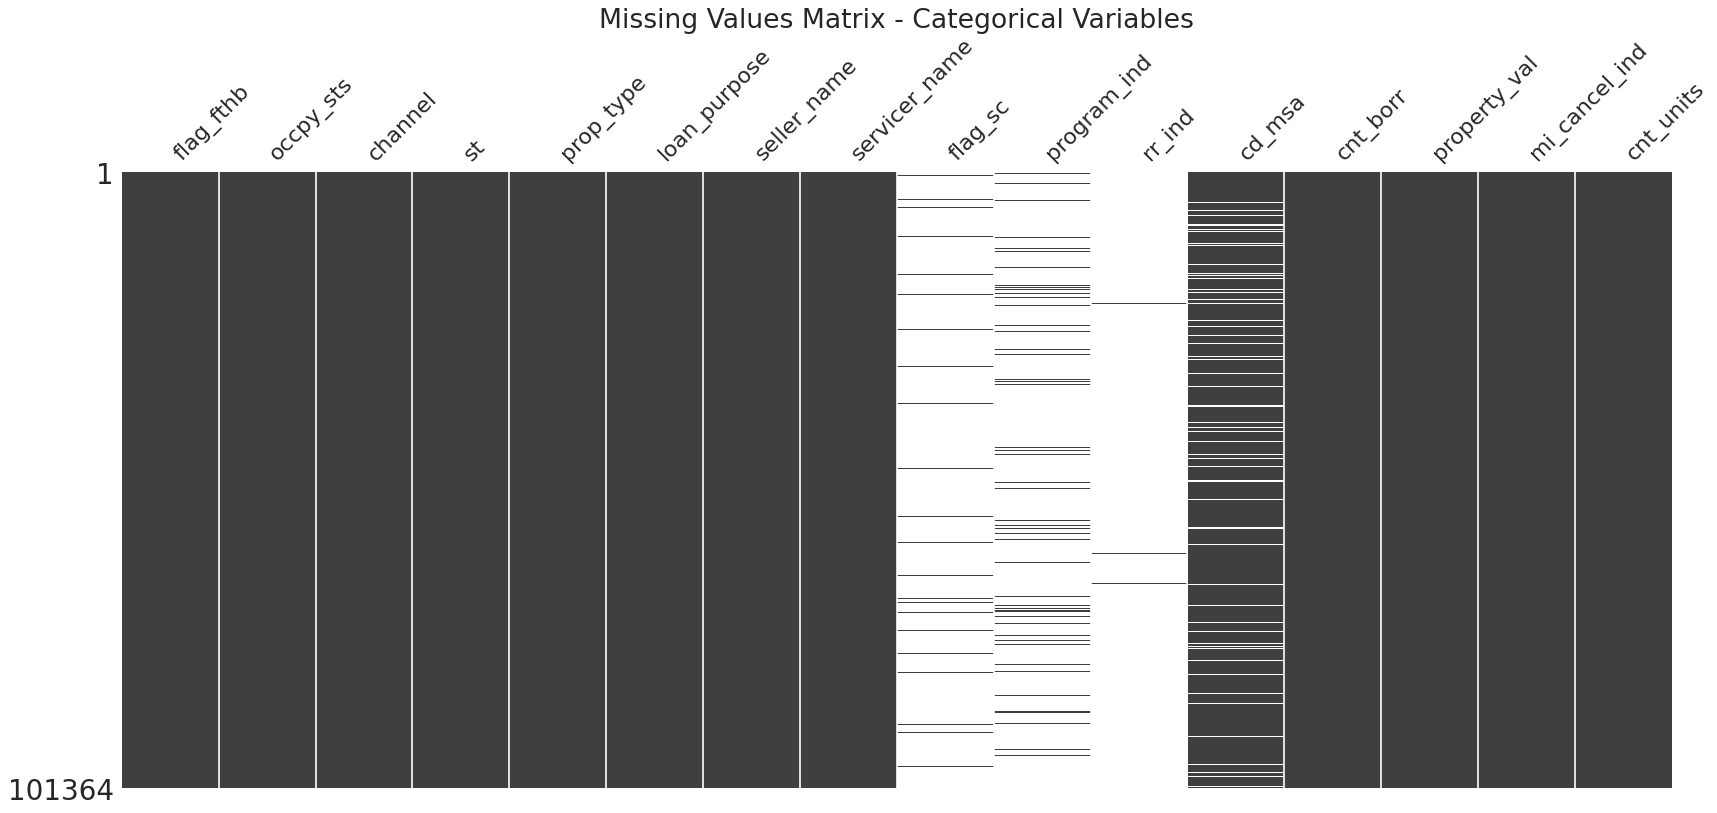

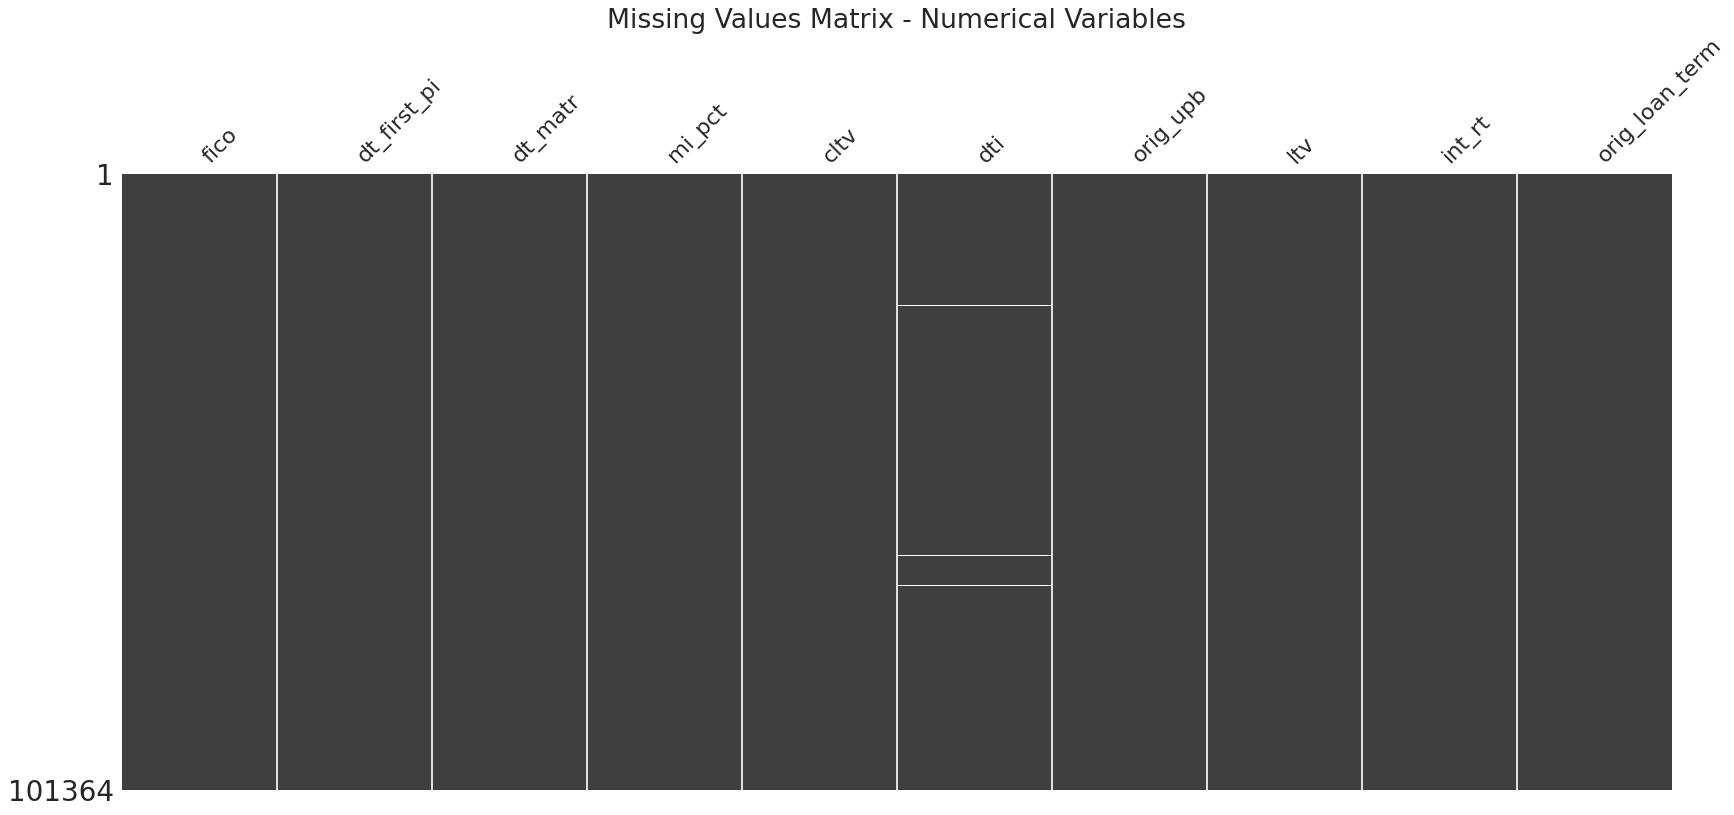

In [21]:
# Convert categorical columns to 'object' dtype for consistency
eda_data[categorical_columns] = eda_data[categorical_columns].astype("object")

# plot missing values
msno.matrix(eda_data[categorical_columns], fontsize=20, sparkline=False)
plt.title("Missing Values Matrix - Categorical Variables", fontsize = 24)
plt.show()

msno.matrix(eda_data[numerical_columns], fontsize=20, sparkline=False)
plt.title("Missing Values Matrix - Numerical Variables", fontsize = 24)
plt.show()


The dataset contains a small number of missing values across both categorical and numerical variables. As shown in the missing value matrices above:

- Categorical variables such as servicer_name, flag_sc, program_ind, rr_ind, and cd_msa have visible missing patterns.

- Numerical variable dti also have some missing entries.

Most other variables are fully observed. Since the proportion of missing values is relatively low, simple imputation (e.g., median for skewed numerical values and constant for categorical features) is feasible.

Through our analysis, we found that the majority of features are complete and do not require imputation. However, for those that do contain missing values, we adopt the following logic to handle them:

- **Drop entire columns** if a variable has too many missing values, making imputation unreliable.

- **Use the mean** to fill in missing values for numerical variables with approximately normal distributions.

- **Use the median** when the variable is skewed and the number of missing values is low.

- **Use the mode** (most frequent category) to impute categorical variables with limited missingness and no special meaning attached to the missing value.

- **Introduce a special category** such as 'missing' for categorical variables where missingness may carry meaningful or structural information.

This strategy ensures that we retain as much useful data as possible while minimizing the risk of introducing bias or data leakage during preprocessing.

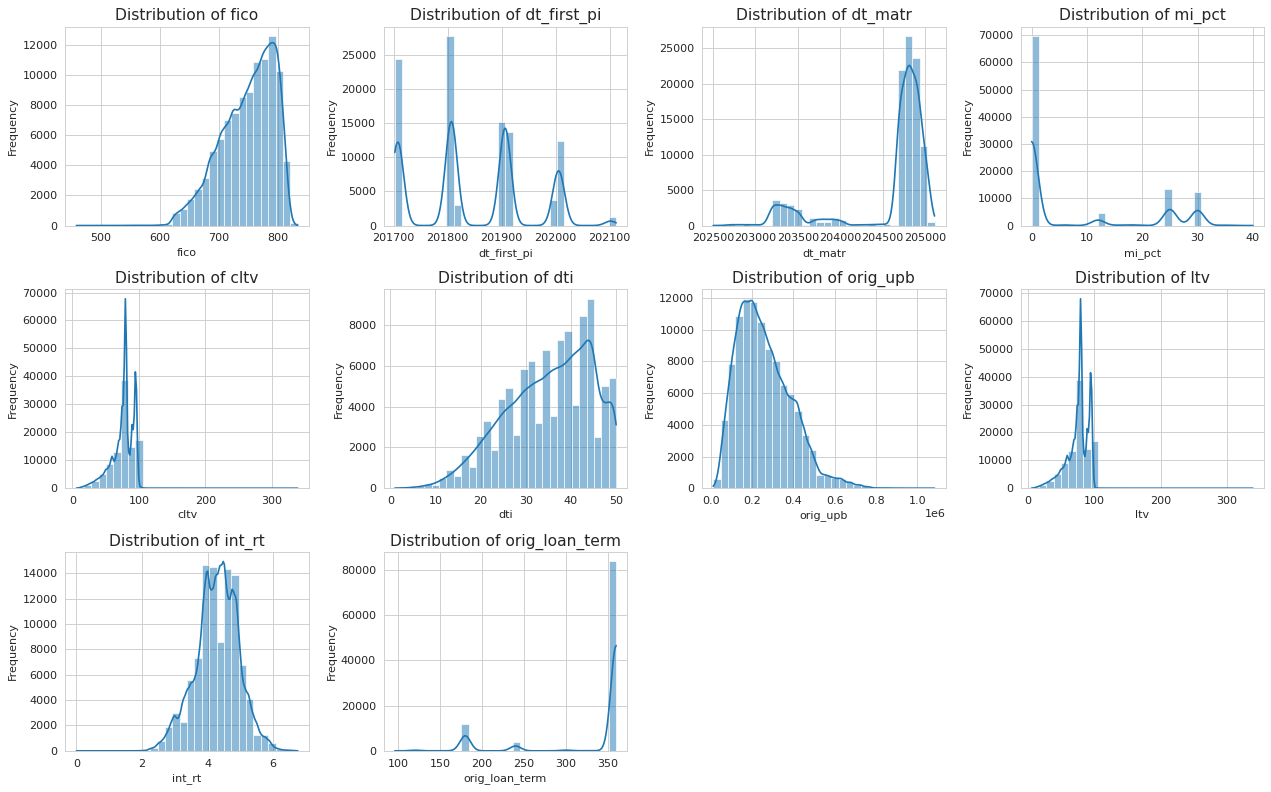

In [22]:
# Then we need to find out the distribution of numerical varaiables
# define plot set
n_cols = 4
n_rows = math.ceil(len(numerical_columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols,figsize=(16,10))
axes = axes.flatten()

# plot
for i, col in enumerate(numerical_columns):
    sns.histplot(eda_data[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Distribution Analysis of Numerical Features
The figure above displays the distributions of key numerical variables used in the model. Several important observations are summarized as follows:

- fico and dti show strong right-skewed distributions, indicating a large proportion of borrowers have relatively high FICO scores and low debt-to-income ratios. Due to this skewness, imputing missing values using the median is more appropriate than using the mean.

- cltv and ltv exhibit very similar distribution shapes, both showing a sharp concentration around 80–100. This suggests potential redundancy between the two features. Further correlation analysis will be conducted later to assess their multicollinearity and decide whether both should be retained in the final model.

- mi_pct (mortgage insurance percentage) displays an extremely irregular and skewed distribution, with a majority of values at zero and scattered peaks at specific insurance bands (e.g., 20%, 30%). This pattern may reflect business rules rather than organic variability.

- dt_first_pi and dt_matr (first payment date and maturity date) show patterns aligned with calendar cycles (e.g., spikes at specific months/years), which may not contribute to predictive power unless transformed into derived features such as loan duration.

- int_rt (interest rate) appears fairly normally distributed, which is ideal for many models and unlikely to need transformation.



### Missing Value Imputation Strategy
Based on the visualizations above and careful inspection of each variable, we applied the following tailored imputation strategies:

**fico**: Since the distribution is skewed, we filled missing values using the median.

**cd_msa**: Missing values may indicate loans from non-metropolitan areas, so we introduced a new category 'missing' to represent them.

**mi_pct**: This column has only one missing value, which we handled by directly dropping the corresponding row.

**cltv**: With only six missing values, we also dropped those rows instead of imputing.

**dti**: The variable is skewed, so we filled in missing values with the median.

**ltv**: There are only two missing values, so we dropped those rows.

**flag_sc**: Missing values are interpreted as "No", and we replaced them with the category 'N'.

**id_loan_rr**: This variable is not used in downstream modeling and was therefore ignored.

**program_ind**: Missing values might carry meaning, so we created a new category 'missing' to capture them.

**rr_ind**: Similar to flag_sc, we interpreted missingness as "No" and replaced with 'N'.

This mixed strategy balances domain logic, data quality, and statistical distribution, ensuring robust preparation before modeling.

In [23]:
# Missing value imputation
def clean_data(df):
    df = df.copy()
    
    # drop na
    df = df[df['mi_pct'].notna()]
    df = df[df['cltv'].notna()]
    df = df[df['ltv'].notna()]
    
    # add new group
    df['flag_sc'] = df['flag_sc'].fillna('N')
    df['program_ind'] = df['program_ind'].fillna('missing')
    df['rr_ind'] = df['rr_ind'].fillna('N')
    df['cd_msa'] = df['cd_msa'].apply(lambda x: 'Not Available' if pd.isna(x) or x == 'Not Available' else 'Available')

    return df

X_train_clean = clean_data(X_train)
X_test_clean = clean_data(X_test)
eda_data=clean_data(eda_data)


## 2.4 Investigating Relationships

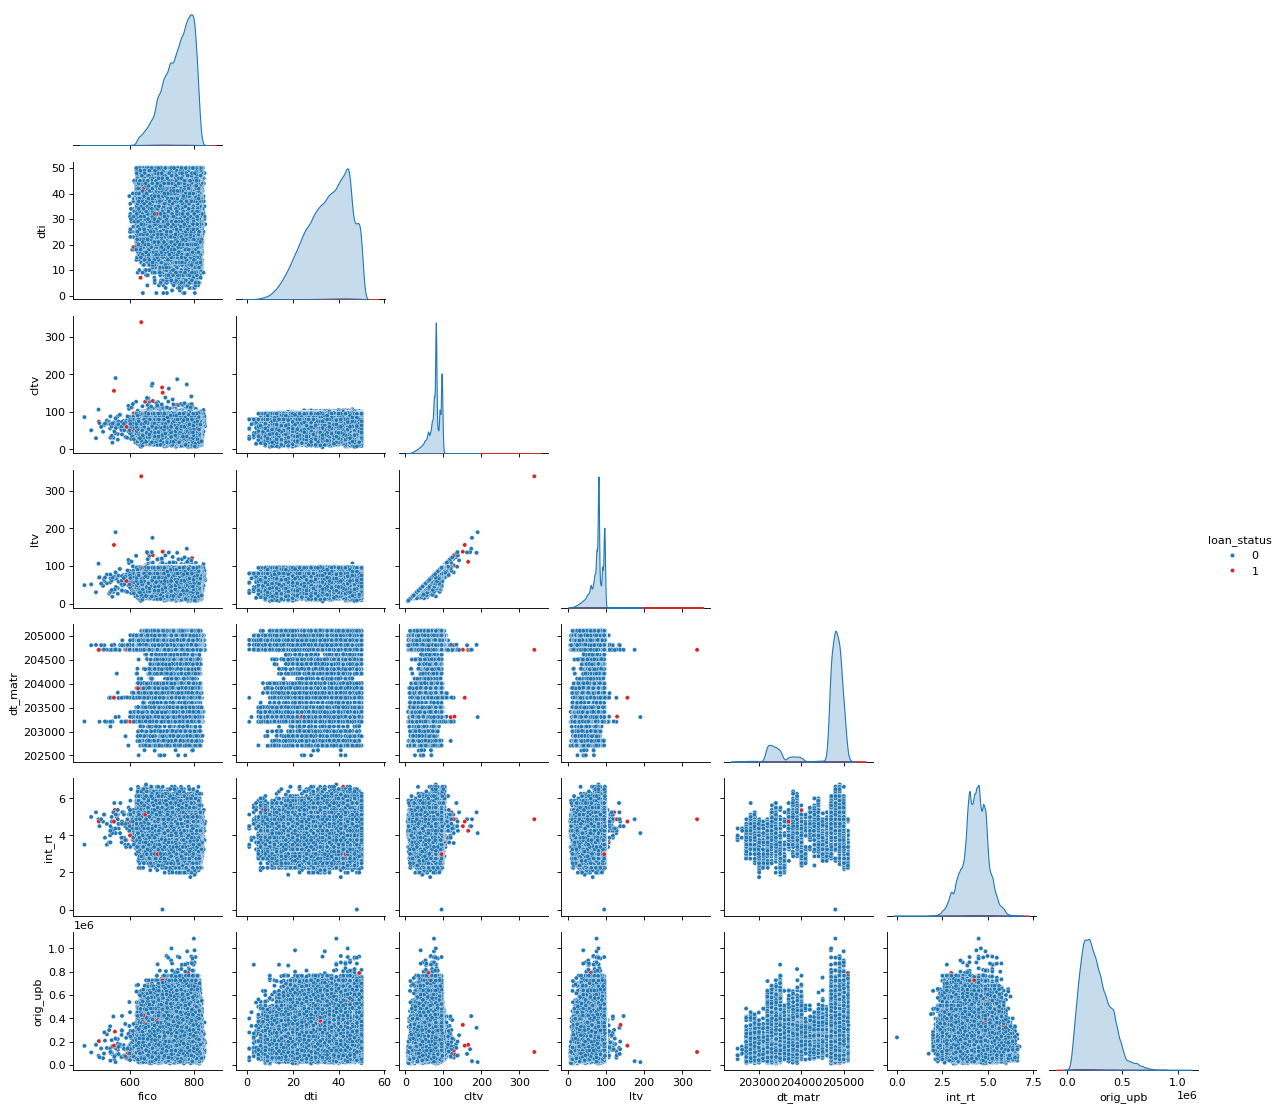

In [10]:
# we now create a pairplot to investigate the relationships between the variables
# set variables to plot
pair_vars = ['fico', 'dti', 'cltv', 'ltv' ,'dt_matr' , 'int_rt', 'orig_upb']

sns.pairplot(
    data=eda_data[pair_vars + ['loan_status']],
    hue='loan_status',
    palette=['#1f77b4','#d62728'],
    corner=True,
    plot_kws={'alpha': 1, 's': 15}
).fig.set_size_inches(16, 14)


### Feature Pairwise Relationships with Target Overlay
The pair plots above visualize the pairwise relationships between key numerical features (fico, dti, cltv, ltv, dt_matr, int_rt, and orig_upb) and their distributions, with the loan outcome (loan_status) overlaid using color. In this context:

- Blue points represent loans that were prepaid (loan_status = 0)

- Red points represent loans that defaulted (loan_status = 1)

This color overlay helps to intuitively observe how the distribution of feature values differs between the two outcome groups.

Most red points (defaults) are scattered sparsely, suggesting that defaults are rare and the data is highly imbalanced.

cltv and ltv exhibit very similar distributions, reinforcing our earlier observation. A strong correlation between them is likely and should be formally checked to avoid multicollinearity in modeling.

fico and dti are right-skewed (positively skewed), with a high density of observations at lower fico scores and higher dti ratios among defaulters. These features may benefit from transformation or binning, especially since they carry strong domain relevance.


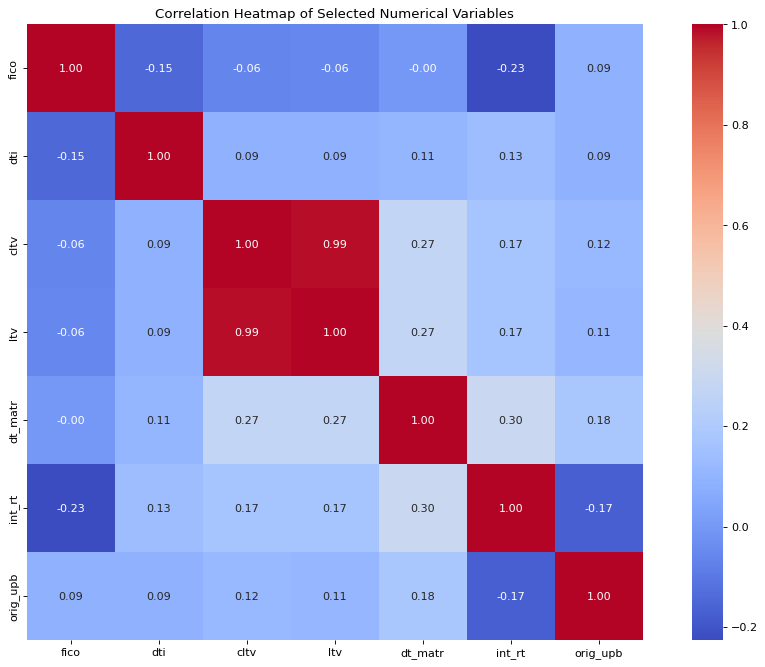

In [11]:
# plot heatmap
corr_matrix = eda_data[pair_vars].corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap of Selected Numerical Variables")
plt.show()

From this figure we can find that the correlation between ltv and cltv is extremely strong. Although the features cltv and ltv are highly correlated, we decided to retain both in the dataset. This is because our modeling approach includes LASSO regularized logistic regression and Random Forest, both of which are capable of handling multicollinearity. Therefore, we did not remove either feature to preserve potentially useful information.



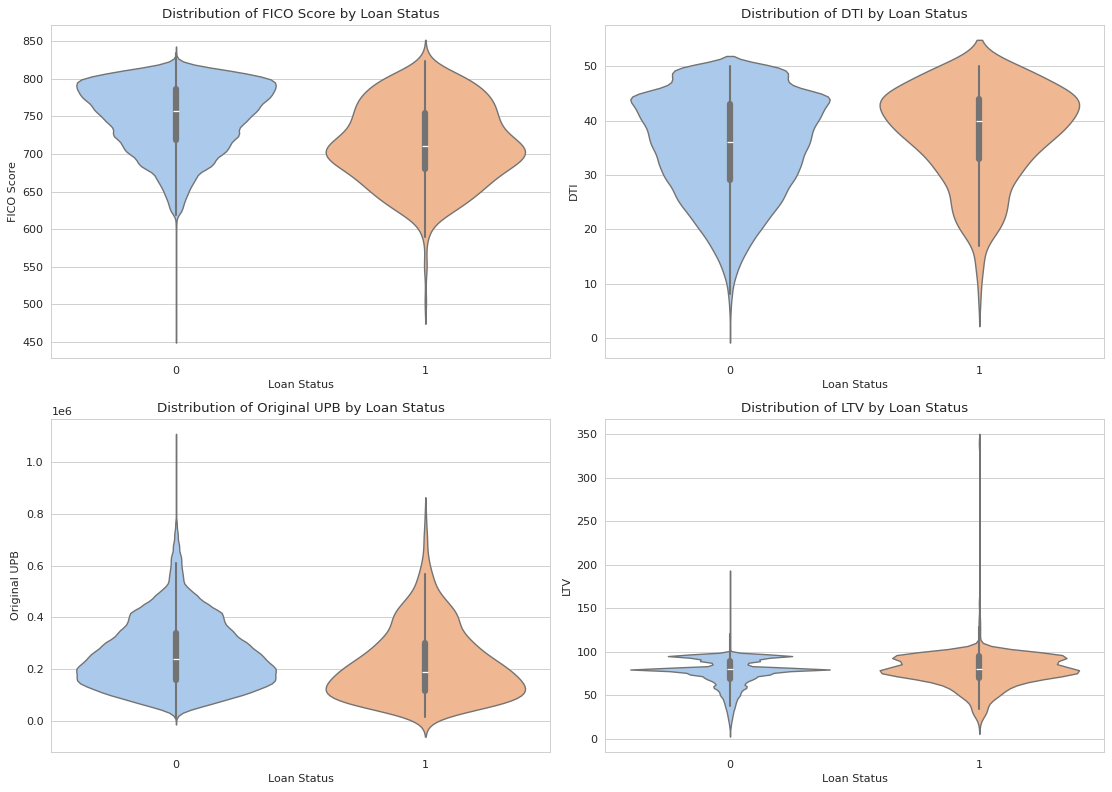

In [24]:
# Create a 2x2 subplot for four violin plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns

# Plot 1: FICO distribution by loan status
sns.violinplot(x='loan_status', y='fico', data=eda_data, palette='pastel', ax=axes[0, 0])
axes[0, 0].set_title("Distribution of FICO Score by Loan Status")
axes[0, 0].set_xlabel("Loan Status")
axes[0, 0].set_ylabel("FICO Score")

# Plot 2: DTI distribution by loan status
sns.violinplot(x='loan_status', y='dti', data=eda_data, palette='pastel', ax=axes[0, 1])
axes[0, 1].set_title("Distribution of DTI by Loan Status")
axes[0, 1].set_xlabel("Loan Status")
axes[0, 1].set_ylabel("DTI")

# Plot 3: Original UPB distribution by loan status
sns.violinplot(x='loan_status', y='orig_upb', data=eda_data, palette='pastel', ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Original UPB by Loan Status")
axes[1, 0].set_xlabel("Loan Status")
axes[1, 0].set_ylabel("Original UPB")

# Plot 4: LTV distribution by loan status
sns.violinplot(x='loan_status', y='ltv', data=eda_data, palette='pastel', ax=axes[1, 1])
axes[1, 1].set_title("Distribution of LTV by Loan Status")
axes[1, 1].set_xlabel("Loan Status")
axes[1, 1].set_ylabel("LTV")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Feature Distributions by Loan Status
The violin plots illustrate the distribution of key numerical variables (FICO, DTI, Original UPB, and LTV) across different loan statuses (0: prepaid, 1: default):

- FICO Score: Borrowers who defaulted (loan_status = 1) generally have lower FICO scores than those who prepaid, with the distribution noticeably shifted to the left.

- DTI (Debt-to-Income Ratio): Defaulted borrowers tend to have slightly higher DTI values on average, suggesting more financial burden.

- Original UPB: The original unpaid principal balance (orig_upb) is more spread out in the prepaid group, while defaulted loans tend to cluster around lower UPB values.

- LTV (Loan-to-Value Ratio): There is a clear difference in LTV distribution, with defaults showing a heavier concentration of high LTV loans, indicating higher risk lending.

These patterns suggest that FICO, DTI, and LTV are all potentially predictive of loan default behavior and worth including in our modeling.

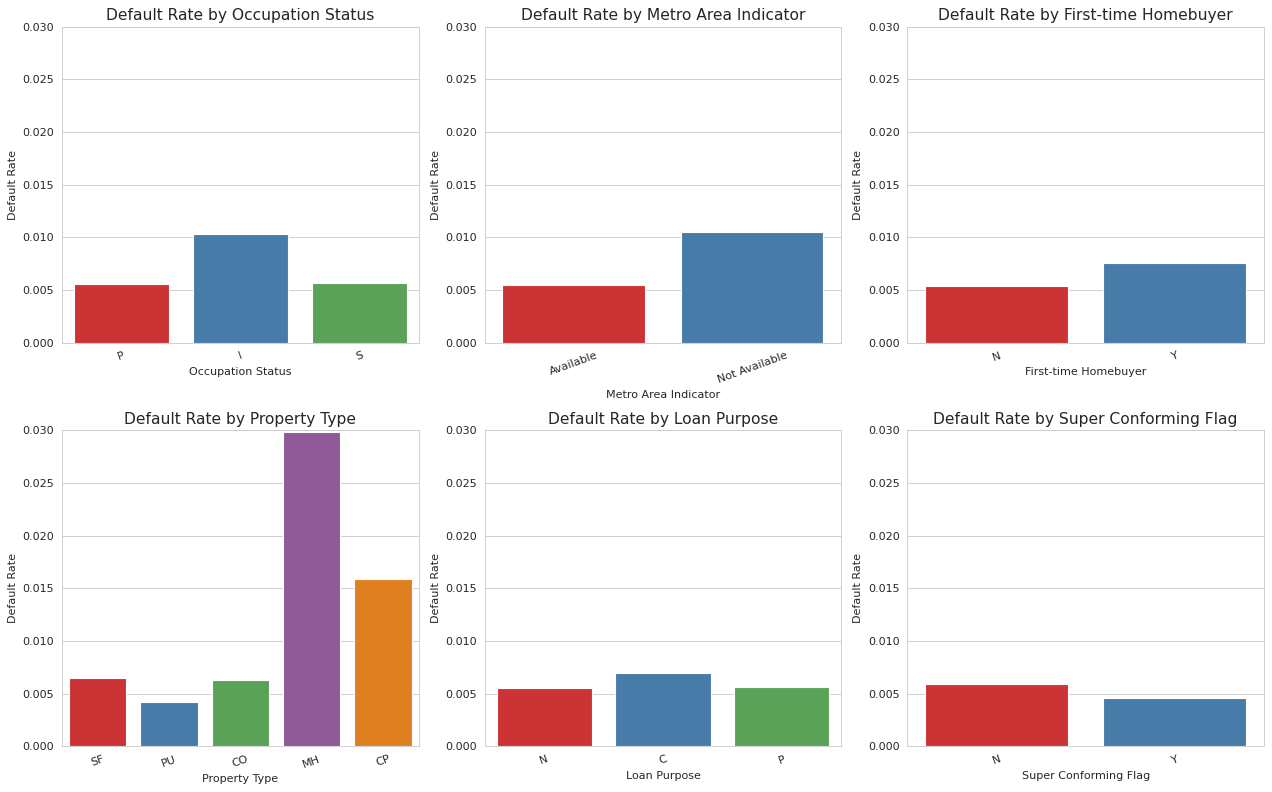

In [25]:
# Set plot style and resolution
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (4, 5)
plt.rcParams['figure.dpi'] = 80

# Define categorical variables and their display titles
categorical_vars = ['occpy_sts', 'cd_msa', 'flag_fthb', 'prop_type', 'loan_purpose', 'flag_sc']
titles = [
    "Occupation Status",
    "Metro Area Indicator",
    "First-time Homebuyer",
    "Property Type",
    "Loan Purpose",
    "Super Conforming Flag"
]

# Create a 2-row, 3-column grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Use a vivid, high-contrast color palette
contrast_palette = sns.color_palette("Set1")

# Draw bar plots for each categorical variable
for i, var in enumerate(categorical_vars):
    sns.barplot(
        x=var, y='loan_status', data=eda_data,
        palette=contrast_palette, ax=axes[i], ci=None
    )
    axes[i].set_title(f"Default Rate by {titles[i]}", fontsize=14)
    axes[i].set_xlabel(titles[i])
    axes[i].set_ylabel("Default Rate")
    axes[i].set_ylim(0, 0.03)  # Standardize Y axis scale for better comparison
    axes[i].tick_params(axis='x', rotation=20)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

### Categorical Features and Default Rate
The bar plots above show the default rate across several categorical variables. Each subplot represents one feature, grouped by its categories, with the corresponding default rate on the y-axis.

Several patterns emerge from the plots:

Property Type shows the most striking difference: loans for Manufactured Homes (MH) have significantly higher default rates than other property types.

Metro Area Availability and Occupation Status also exhibit some differences—loans from areas marked Not Available or with certain occupation codes tend to have slightly higher risk.

Other variables such as Loan Purpose, First-time Homebuyer Flag, and Super Conforming Flag show only modest variation between categories.

These insights help identify potentially risky segments and guide feature selection or transformation in downstream modeling.

## 2.5 Feature Engineering
To enhance model performance, we applied several feature engineering techniques. Categorical variables were transformed using One-Hot Encoding to make them compatible with machine learning models while preserving important group information. For missing values, we used tailored strategies including median imputation for numerical variables and assigning special categories for categorical ones. In addition, we carefully removed low-variance or redundant features based on domain knowledge to reduce noise and improve interpretability. These preprocessing steps ensured the model received clean and informative inputs for training.



# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

In this task, one of the most critical challenges is the severe class imbalance between default and prepaid loans. To address this, we explored a variety of machine learning models including Logistic Regression, LASSO, Random Forest, and XGBoost. Each of these models brings unique advantages: Logistic Regression offers high interpretability and serves as a solid baseline; LASSO enhances this by performing feature selection via regularization, reducing overfitting; Random Forest captures nonlinear interactions and is robust to noise; and XGBoost provides powerful boosting capabilities and often yields strong predictive performance in imbalanced settings.

To mitigate the imbalance issue, we also experimented with both oversampling and undersampling strategies, such as SMOTE and Random Undersampling, as well as hybrid techniques like SMOTETomek and SMOTEENN.

To establish a performance baseline, we first fitted a standard logistic regression model without any resampling. This allowed us to evaluate the added benefit of more complex models and sampling techniques. Then we fit different models with different sampling strategies.

After fitting all candidate models, we moved to the model selection phase. Our choice of the final model was guided by two primary criteria: interpretability and predictive accuracy. Interpretability was important because the client requested not only a prediction tool but also insights into which features contribute to default risk. At the same time, we aimed to maximize prediction performance.

In real-world financial applications, the cost of wrongly approving a high-risk loan (a false negative) is typically much higher than that of incorrectly rejecting a low-risk applicant (a false positive). While we do not have a quantifiable cost function to reflect this trade-off, we adjusted our evaluation focus accordingly. As such, we prioritized recall—the proportion of actual defaults correctly identified by the model—as a key metric. A higher recall indicates fewer missed defaulters, which is critical for minimizing financial losses. In addition to recall, we also considered ROC-AUC and accuracy to ensure overall model robustness and balance.

Among all models tested, we ultimately selected the random forest model combined with undersampling as our final model, due to its strong performance across multiple metrics—especially recall and ROC AUC—while maintaining a relatively straightforward structure that supports interpretation of feature importance.

## 3.1 Baseline Model
We used a Logistic Regression model as our baseline. Before fitting the model, we built a preprocessing pipeline to handle missing values and categorical variables. For numeric features like fico and dti, missing values were filled with the median. For categorical variables, we used constant value filling and one-hot encoding. The model was trained with balanced class weights to address class imbalance. This baseline helps us compare the performance of more advanced models later.

 Evaluation Metrics (baseline)
------------------------------
Accuracy       : 0.6701
Precision      : 0.0099
Recall         : 0.5570
F1 Score       : 0.0195
ROC AUC Score  : 0.6656


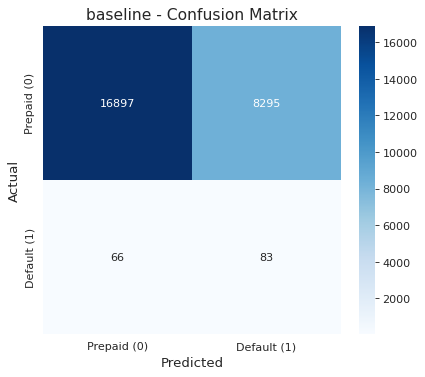

{'accuracy': 0.6700603764650171,
 'precision': 0.009906899021246121,
 'recall': 0.5570469798657718,
 'f1': 0.01946757358977366,
 'roc_auc': np.float64(0.6656307744442148),
 'confusion_matrix': array([[16897,  8295],
        [   66,    83]])}

In [26]:
# data imputation
numerical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# fill na and on-hot coding for categorical varaiables
categorical_imputer_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_imputer, ['fico', 'dti']),
    ('cat', categorical_imputer_encoder, categorical_columns)
], remainder='passthrough')

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train_clean, y_train)

classification_model_fit(pipe,X_test_clean,y_test,model_name="baseline")

## 3.2 Final Model: Random Forest with Undersampling
To address the class imbalance between default and prepaid loans, we implemented a Random Forest classifier combined with random undersampling. The model was built using a pipeline that first applies preprocessing (missing value imputation and One-Hot Encoding), then performs random undersampling to balance the training data, and finally fits a Random Forest classifier with class-weight adjustment to handle any remaining imbalance.

To evaluate model stability, we conducted 5-fold stratified cross-validation using recall as the primary scoring metric, which is particularly relevant for this task as we aim to reduce false negatives (i.e., failing to detect high-risk defaults). The cross-validated recall scores ranged from 0.68 to 0.74, with a mean recall of 0.72, indicating consistent performance across folds.

On the hold-out test set, the model achieved a recall of 0.7181, a ROC AUC of 0.7876, and an overall accuracy of 0.7363. The confusion matrix shows that the model was able to correctly identify 107 defaults, missing only 42, which is crucial in a context where failing to detect defaults can lead to significant financial losses.

We selected this model as the final choice due to its strong performance on recall, interpretability through feature importance, and robustness achieved through ensemble learning. Moreover, the undersampling strategy helped mitigate the bias toward the majority class without requiring synthetic data generation.



Other models were excluded due to either poor predictive performance or limited interpretability.
Lasso regression, while interpretable, showed low recall (max 0.65), making it unreliable for identifying defaults.
XGBoost achieved high recall and AUC, but it is difficult to interpret — a key requirement for this task.
Some models like SMOTE-only logistic regression had recall below 0.52, and others like plain Random Forest had zero recall, failing to detect any defaults.
Therefore, these models did not offer a better balance between accuracy and interpretability compared to our chosen model.

Cross-validated Recall Scores: [0.78151261 0.68067227 0.73333333 0.74166667 0.67226891]
Mean Recall: 0.721890756302521
 Evaluation Metrics (Random Forest + Undersampling)
------------------------------
Accuracy       : 0.7363
Precision      : 0.0159
Recall         : 0.7181
F1 Score       : 0.0310
ROC AUC Score  : 0.7876


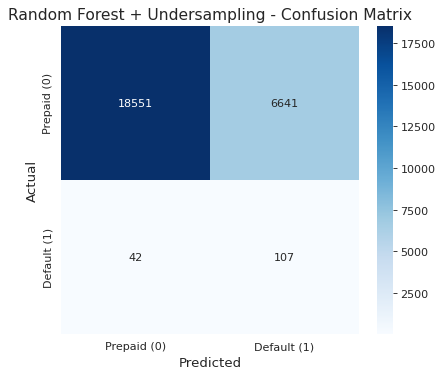

{'accuracy': 0.7362771792746932,
 'precision': 0.015856550088915233,
 'recall': 0.7181208053691275,
 'f1': 0.03102798318109323,
 'roc_auc': np.float64(0.7875561326595638),
 'confusion_matrix': array([[18551,  6641],
        [   42,   107]])}

In [27]:
# Construct pipeline with undersampling and Random Forest, and add preprocessing (OneHot + Imputation)
rf_under_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),  # Apply preprocessing (e.g., OneHotEncoder + missing value imputation)
    ('sampler', RandomUnderSampler(random_state=42)),  # Perform random undersampling to balance classes
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ))  # Train Random Forest with class_weight balancing
])

# Define Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optional: use recall as primary evaluation metric
recall_scorer = make_scorer(recall_score)

# Perform cross-validation with recall as the main scoring metric
cv_scores = cross_val_score(
    rf_under_pipeline,
    X_train_clean,
    y_train,
    scoring=recall_scorer,  # You can also use 'roc_auc', 'accuracy', etc.
    cv=cv,
    n_jobs=-1  # Use all cores for parallel processing
)

# Print cross-validated recall scores
print("Cross-validated Recall Scores:", cv_scores)
print("Mean Recall:", cv_scores.mean())

# Final fit on the full training set (for test evaluation)
rf_under_pipeline.fit(X_train_clean, y_train)

# Evaluate model on test set using custom function
classification_model_fit(
    rf_under_pipeline,
    X_test_clean,
    y_test,
    model_name="Random Forest + Undersampling"
)


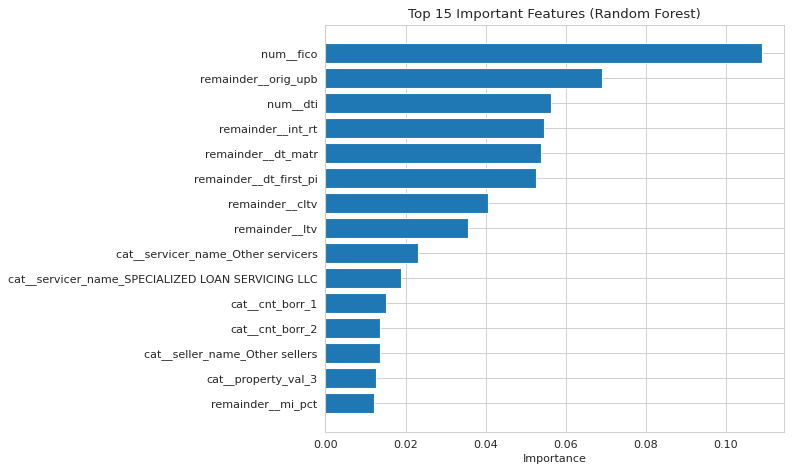

In [28]:
# extract classifier
rf_model = rf_under_pipeline.named_steps['classifier']

feature_names = rf_under_pipeline.named_steps['preprocess'].get_feature_names_out()

importances = rf_model.feature_importances_


# buile DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:15][::-1], feat_imp_df['Importance'][:15][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Important Features (Random Forest)')
plt.tight_layout()
plt.show()


## 3.3 Identifying High-Risk Factors
To identify key drivers of default risk, we utilized the built-in feature importance attribute of the Random Forest classifier. This method evaluates how frequently and effectively each variable is used in decision tree splits across the ensemble, thus highlighting which features contribute most to the model's predictions. Specifically, we fitted our final model (Random Forest with undersampling and preprocessing) and extracted the top 15 most important features based on the feature_importances_ attribute.

The bar chart above displays the relative importance of each feature. As observed, fico score stands out as the most influential predictor, with an importance score exceeding 0.10. This confirms expectations, as a lower FICO score is generally indicative of poor creditworthiness and higher default risk. Other high-impact variables include:

orig_upb (original unpaid balance): Larger loan amounts may correspond to higher risk due to increased financial burden.

dti (debt-to-income ratio): A higher DTI signals financial strain, which increases the chance of default.

int_rt (interest rate): Higher interest rates imply larger monthly payments and a greater chance of delinquency.

ltv / cltv (loan-to-value ratios): High values suggest less equity in the property, reducing collateral security for lenders.

Additionally, some categorical features such as servicer_name, seller_name, and number of borrowers also appear, indicating that institutional factors and borrower composition can influence default risk.

Potential High-Risk Profiles
Based on these insights, we can preliminarily define potential high-risk individuals as those who:

Have a low FICO score,

Carry high loan amounts with limited down payments (high LTV/CLTV),

Face high monthly payment obligations (due to high DTI or interest rate),

And possibly originate from certain servicers or sellers with historically higher default patterns.

This information can be valuable not only for predictive modeling but also for future risk control strategies and lending policy adjustments.



# Discussion & Conclusions


Our final model—a Random Forest classifier with undersampling—demonstrated strong performance in identifying high-risk mortgage defaults. With a recall of approximately 0.72, the model effectively captures the majority of actual defaults, making it highly suitable for real-world applications where missing a high-risk loan could result in significant financial loss. Additionally, the model maintains a reasonable AUC score of 0.79, indicating solid overall classification ability.

Using feature importance analysis, we identified FICO score, original unpaid balance (UPB), debt-to-income ratio (DTI), and interest rate as the most influential variables. This provides valuable insight into the key drivers of default risk, and supports targeted risk management strategies for lending institutions. These results are interpretable and actionable, enabling banks to prioritize customers with low credit scores, high loan amounts, and less favorable financial profiles.

While the model performs well, one major limitation lies in the absence of a defined cost or loss function. In practice, the cost of misclassifying a defaulter (false negative) is much higher than wrongly rejecting a safe borrower (false positive). However, our data does not quantify these costs, so we are unable to fully incorporate cost-sensitive learning or precisely evaluate the financial consequences of prediction errors.

Despite this, the high recall ensures that most potential defaults are captured, aligning with the institution’s need to minimize financial risk. Looking ahead, integrating actual financial loss values and applying cost-sensitive training could further enhance decision-making accuracy. Additionally, the model could be adapted to flag active loans at risk, allowing timely interventions such as restructured repayment plans or enhanced monitoring.

In summary, our model balances predictive performance with interpretability, and serves as a practical tool for identifying high-risk loans and supporting credit risk assessment in the mortgage lending process.



# Generative AI statement

Generative AI tools (specifically, ChatGPT) were used throughout the project to assist in several areas. These included generating data visualization code (e.g., plotting feature importance and distribution charts), identifying and resolving coding errors during model development, and improving the clarity and fluency of the written report. 

# References

*Include references if any*

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# smote过采样

# 数值变量填补器（中位数）
numerical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# 类别变量填补器 + 编码器
categorical_imputer_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 合并预处理器
# 所有数值变量（包括被 passthrough 的）
numerical_features = ['fico', 'dti', 'dt_first_pi', 'dt_matr', 'mi_pct', 'cltv', 'orig_upb', 'ltv', 'int_rt', 'orig_loan_term']

# 更新 ColumnTransformer（显式列出所有列，不用 passthrough）
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_imputer, ['fico', 'dti']),
    ('cat', categorical_imputer_encoder, categorical_columns),
    ('num_passthrough', 'passthrough', ['dt_first_pi', 'dt_matr', 'mi_pct', 'cltv', 'orig_upb', 'ltv', 'int_rt', 'orig_loan_term'])
])


# 构建带 SMOTE 的管道
pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),  # 数据预处理
    ('smote', SMOTE(random_state=42)),  # SMOTE 过采样
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))  # 分类器
])

# 模型训练
pipeline.fit(X_train_clean, y_train)

classification_model_fit(pipeline,X_test_clean,y_test)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression

# 构建欠采样管道
pipeline_under = ImbPipeline(steps=[
    ('preprocess', preprocessor),  # 数据预处理（用你原本的 preprocessor）
    ('undersample', RandomUnderSampler(random_state=42)),  # 欠采样器
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))  # 分类器
])

# 模型拟合
pipeline_under.fit(X_train_clean, y_train)

# 模型评估
classification_model_fit(pipeline_under, X_test_clean, y_test, model_name="LogReg + UnderSampling")

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression

# 构建带有 SMOTETomek 的混合采样管道
hybrid_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),  # 数据预处理器，含数值填补 + OneHot 编码
    ('sampler', SMOTETomek(random_state=42)),  # 采样器（SMOTE 过采样 + Tomek 欠采样）
    ('classifier', LogisticRegression(
        class_weight='balanced',  # 处理类别不平衡
        max_iter=1000,
        random_state=42
    ))
])

# 模型训练（使用清洗后的训练集）
hybrid_pipeline.fit(X_train_clean, y_train)

# 模型评估（调用统一输出函数）
classification_model_fit(
    hybrid_pipeline,
    X_test_clean,
    y_test,
    model_name="Logistic + SMOTETomek"
)


In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline  # 可选
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# 构建 Pipeline，加入预处理器和 L1 模型
lasso_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),  # 复用你之前定义好的 preprocessor
    ('classifier', LogisticRegression(
        penalty='l1',              # 使用 L1 正则化
        solver='saga',       # liblinear 支持 l1
        class_weight='balanced',  # 处理不平衡
        max_iter=1000,
        random_state=42
    ))
])

# 模型训练
lasso_pipeline.fit(X_train_clean, y_train)

# 模型评估
classification_model_fit(lasso_pipeline, X_test_clean, y_test, model_name="LASSO Logistic Regression")


In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# 构建使用 L1 正则化（LASSO）并结合 SMOTE 的 Pipeline
lasso_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),  # 复用已有的 ColumnTransformer
    ('smote', SMOTE(random_state=42)),  # SMOTE 过采样
    ('classifier', LogisticRegression(
        penalty='l1',              # L1 正则化 = LASSO
        solver='saga',       # 支持 L1 的求解器
        class_weight='balanced',  # 处理类别不平衡
        max_iter=1000,
        random_state=42
    ))
])

# 模型训练
lasso_pipeline.fit(X_train_clean, y_train)

# 模型评估（含预测结果 + ROC）
classification_model_fit(lasso_pipeline,X_test_clean,y_test,model_name="LASSO + SMOTE")


In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
# 4. 构建带有欠采样和 L1 正则化的 LASSO 模型管道
lasso_undersampling_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

# 5. 模型拟合
lasso_undersampling_pipeline.fit(X_train_clean, y_train)

# 6. 模型评估（使用你之前定义的评估函数）
classification_model_fit(lasso_undersampling_pipeline, X_test_clean, y_test,
                         model_name="LASSO + Undersampling")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# 构建随机森林的 Pipeline，其中设置 class_weight='balanced' 以应对类别不均衡
rf_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),  # 这个会进行 OneHotEncoding 和数值填补
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# 拟合训练集
rf_pipeline.fit(X_train_clean, y_train)

# 可选：统一输出评估指标和曲线（如果你封装了这个函数）
classification_model_fit(rf_pipeline, X_test_clean, y_test, model_name="Random Forest")

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# 构建包含 SMOTE 的随机森林管道
# 构建完整 pipeline
rf_smote_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),  # 添加预处理器：包含 OneHot + Imputer
    ('sampler', SMOTE(random_state=42)),  # SMOTE 过采样
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ))
])

# 模型训练（使用清洗过的训练集）
rf_smote_pipeline.fit(X_train_clean, y_train)

# 模型评估（统一输出指标）
classification_model_fit(
    rf_smote_pipeline,
    X_test_clean,
    y_test,
    model_name="Random Forest + SMOTE"
)


In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

# 构建欠采样随机森林模型的 Pipeline（加入预处理器）
rf_under_pipeline = ImbPipeline([
    ('preprocess', preprocessor),  # 添加预处理器（OneHot + 填补）
    ('sampler', RandomUnderSampler(random_state=42)),  # 欠采样处理
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ))
])

# 模型训练（用清洗过的训练集）
rf_under_pipeline.fit(X_train_clean, y_train)

# 模型评估（输出指标和曲线）
classification_model_fit(
    rf_under_pipeline,
    X_test_clean,
    y_test,
    model_name="Random Forest + Undersampling"
)

In [ ]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# 构建 XGBoost 模型的 Pipeline（不含采样器）
xgb_plain_pipeline = Pipeline([
    ('preprocess', preprocessor),  # 预处理器：数值填补、类别编码
    ('classifier', XGBClassifier(
        use_label_encoder=False,  # 避免警告，不影响新版本
        eval_metric='logloss',
        random_state=42
    ))
])

# 模型训练（用清洗过的数据）
xgb_plain_pipeline.fit(X_train_clean, y_train)

# 模型评估
classification_model_fit(
    xgb_plain_pipeline,
    X_test_clean,
    y_test,
    model_name="XGBoost (No Sampling)"
)


In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 构建 XGBoost + SMOTE 的模型流水线
xgb_pipeline = ImbPipeline([
    ('preprocess', preprocessor),  # 包含 OneHot 和缺失值填补的预处理器
    ('sampler', SMOTE(random_state=42)),  # SMOTE 过采样
    ('classifier', XGBClassifier(
        use_label_encoder=False,  # 忽略 label encoder 警告
        eval_metric='logloss',   # 设置评估指标
        random_state=42
    ))
])

# 拟合模型
xgb_pipeline.fit(X_train_clean, y_train)

# 模型评估
classification_model_fit(
    xgb_pipeline,
    X_test_clean,
    y_test,
    model_name="XGBoost + SMOTE"
)

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

# 构建 XGBoost + 欠采样 的模型流水线
xgb_under_pipeline = ImbPipeline([
    ('preprocess', preprocessor),  # 包括 OneHotEncoding 和缺失值填补
    ('sampler', RandomUnderSampler(random_state=42)),  # 欠采样
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# 模型训练
xgb_under_pipeline.fit(X_train_clean, y_train)

# 模型评估
classification_model_fit(
    xgb_under_pipeline,
    X_test_clean,
    y_test,
    model_name="XGBoost + Undersampling"
)